# DLAV Project - Phase 2

The first step is to prepare the data. The code below will download the data from google drive and extract it here for your code to use.

In [1]:
# Install gdown to handle Google Drive file download
import gdown
import zipfile
import os

def folder_exists_and_not_empty(folder):
    return os.path.isdir(folder) and len(os.listdir(folder)) > 0

datasets = {
    "train": ("https://drive.google.com/uc?id=1YkGwaxBKNiYL2nq--cB6WMmYGzRmRKVr", "phase2_dlav_train.zip"),
    "val": ("https://drive.google.com/uc?id=1wtmT_vH9mMUNOwrNOMFP6WFw6e8rbOdu", "phase2_dlav_val.zip"),
    "test_public": ("https://drive.google.com/uc?id=1G9xGE7s-Ikvvc2-LZTUyuzhWAlNdLTLV", "phase2_dlav_test_public.zip")
}


for folder, (url, zip_name) in datasets.items():
    if not folder_exists_and_not_empty("phase2/"+folder):
        print(f"Downloading and extracting {folder} dataset...")
        gdown.download(url, zip_name, quiet=False)

        # Define the target extraction directory
        os.makedirs("phase2", exist_ok=True)  # Ensure the directory exists

        with zipfile.ZipFile(zip_name, 'r') as zip_ref:
            zip_ref.extractall("phase2")  # Extract into the specified directory

        os.remove(zip_name)
    else:
        print(f"{folder} folder already exists and is not empty. Skipping download.")



train folder already exists and is not empty. Skipping download.
val folder already exists and is not empty. Skipping download.
test_public folder already exists and is not empty. Skipping download.


Now lets load the data and visualize the first few examples to see what we are dealing with!

8
8
8
8


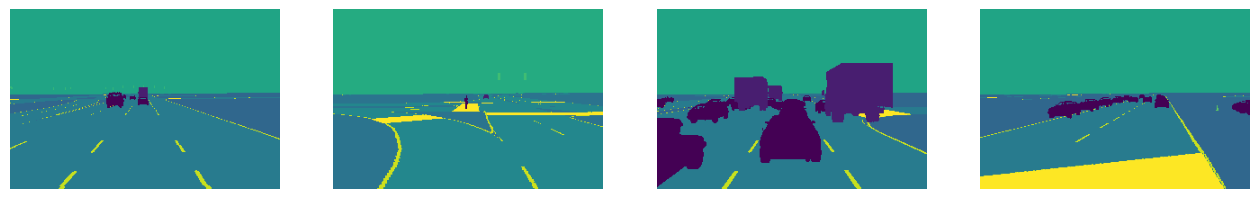

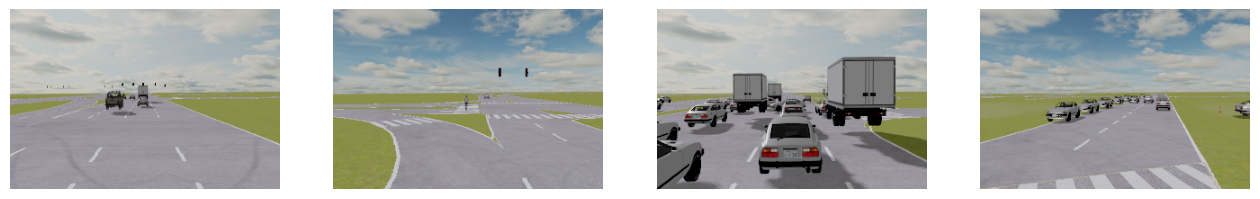

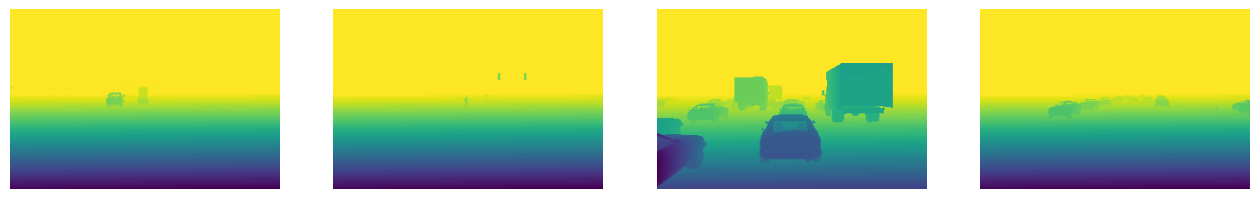

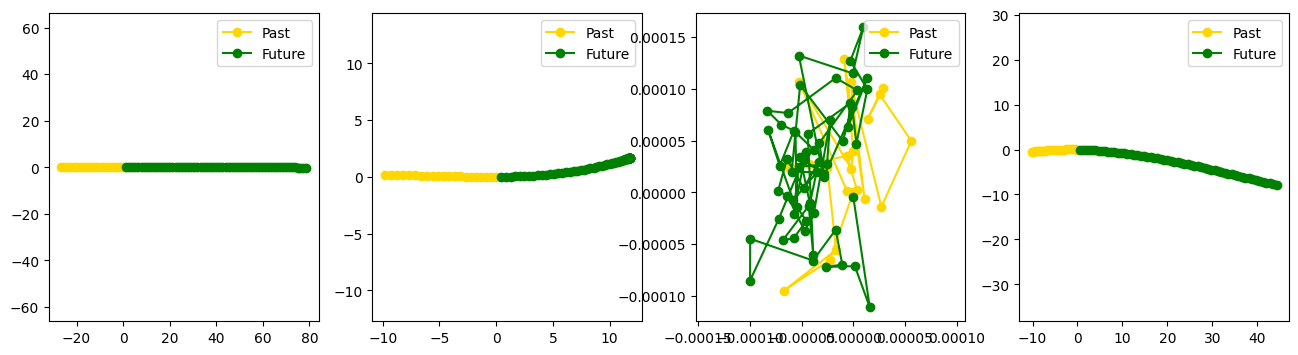

driving_command: forward
driving_command: forward
driving_command: forward
driving_command: forward


In [2]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
import random

k = 4
# load the data
data = []
for i in random.choices(np.arange(1000), k=k):
    with open(f"phase2/train/{i}.pkl", "rb") as f:
        data.append(pickle.load(f))
# plot the camera view of current step for the k examples
fig, axis = plt.subplots(1, k, figsize=(4*k, 4))
for i in range(k):
    print(data[i]["semantic_label"][0][0])
    axis[i].imshow(data[i]["semantic_label"])
    axis[i].axis("off")
plt.show()

# plot the camera view of current step for the k examples
fig, axis = plt.subplots(1, k, figsize=(4*k, 4))
for i in range(k):
    axis[i].imshow(data[i]["camera"])
    axis[i].axis("off")
plt.show()

# plot the camera view of current step for the k examples
fig, axis = plt.subplots(1, k, figsize=(4*k, 4))
for i in range(k):
    axis[i].imshow(data[i]["depth"])
    axis[i].axis("off")
plt.show()

# plot the past and future trajectory of the vehicle
fig, axis = plt.subplots(1, k, figsize=(4*k, 4))
for i in range(k):
    axis[i].plot(data[i]["sdc_history_feature"][:, 0], data[i]["sdc_history_feature"][:, 1], "o-", color="gold", label="Past")
    axis[i].plot(data[i]["sdc_future_feature"][:, 0], data[i]["sdc_future_feature"][:, 1], "o-", color="green", label="Future")
    axis[i].legend()
    axis[i].axis("equal")
plt.show()

for i in range(k):
    print(f"driving_command: {data[i]['driving_command']}")

In [3]:
import torch
import os
print("CUDA available:", torch.cuda.is_available())
print("GPU name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU")


CUDA available: True
GPU name: NVIDIA GeForce RTX 4060 Ti


In [4]:
import os
import torch
import pickle
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import csv
import random
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

class DrivingDataset(Dataset):
    def __init__(self, file_list, test=False):
        self.samples = file_list
        self.test = test

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        with open(self.samples[idx], 'rb') as f:
            data = pickle.load(f)
        
        camera = torch.FloatTensor(data['camera']).permute(2, 0, 1) / 255.0
        history = torch.FloatTensor(data['sdc_history_feature'])

        depth = torch.FloatTensor(data['depth'])
        semantic = torch.FloatTensor(data['semantic_label'])

        if not self.test:
            future = torch.FloatTensor(data['sdc_future_feature'])
            return {
                'camera': camera,
                'history': history,
                'depth': depth,
                'future': future,
                'semantic': semantic
            }
        else:
            return {
                'camera': camera,
                'history': history,
                'depth': depth,
                'semantic': semantic
            }

In [5]:
import matplotlib.pyplot as plt

class Logger:
    def __init__(self):
        # will hold per-epoch losses
        self.history = {'train_loss': [], 'val_loss': []}

    def log_epoch(self, epoch, train_loss, val_loss, **metrics):
        """
        Call once per epoch.
        """
        # store
        self.history['train_loss'].append(train_loss)
        self.history['val_loss'].append(val_loss)

        # print summary
        # metric_str = " | ".join(f"{k}: {v:.4f}" for k,v in metrics.items())
        # print(f"[Epoch {epoch+1}] Train: {train_loss:.4f} | Val: {val_loss:.4f}"
            #   + (f" | {metric_str}" if metric_str else "") )

    def plot(self):
        """
        Call after training to visualize the curves.
        """
        epochs = range(1, len(self.history['train_loss'])+1)
        plt.figure(figsize=(6,4))
        plt.plot(epochs, self.history['train_loss'], label='Train Loss')
        plt.plot(epochs, self.history['val_loss'],   label='Val   Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Loss vs. Epoch')
        plt.legend()
        plt.tight_layout()
        plt.show()


In [6]:
import torch
import torch.nn as nn

class TrajGRU(nn.Module):
    def __init__(self, input_dim=3, hidden_dim=128, num_layers=1):
        super().__init__()
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers=num_layers, batch_first=True)
    
    def forward(self, x):  # x: (B, 21, 3)
        _, h_n = self.gru(x)  # h_n: (num_layers, B, hidden_dim)
        return h_n[-1]  # Take last layer’s hidden state → (B, hidden_dim)


In [7]:
import torch
import torch.nn as nn

class SlimConvNet(nn.Module):
    def __init__(self, in_channels=3):
        super().__init__()

        self.features = nn.Sequential(
            nn.Conv2d(in_channels, 32, 3, padding=1),  # (B, 32, 300, 200)
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),  # (B, 32, 150, 100)

            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),  # (B, 64, 75, 50)

            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((4, 4))  # (B, 128, 4, 4)
        )

        self.flatten = nn.Flatten()
        self.fc = nn.Sequential(
            nn.Linear(128 * 4 * 4, 512),
            nn.ReLU(),
            nn.Dropout(0.2)
        )

    def forward(self, x):
        x = self.features(x)         # (B, 128, 4, 4)
        spatial_features = x         # Save for return
        flat = self.flatten(x)       # (B, 2048)
        flat = self.fc(flat)            # (B, 512)
        return flat, spatial_features               # Return both


In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SemanticDecoder(nn.Module):
    def __init__(self, num_classes=14):
        super().__init__()

        # Input: (B, 128, 4, 4)
        self.up1 = self.up_block(128, 64)   # (B, 64, 8, 8)
        self.up2 = self.up_block(64, 64)    # (B, 64, 16, 16)
        self.up3 = self.up_block(64, 32)    # (B, 32, 32, 32)
        self.up4 = self.up_block(32, 16)    # (B, 16, 64, 64)
        self.up5 = self.up_block(16, 8)     # (B, 8, 128, 128)

        self.out_conv = nn.Conv2d(8, num_classes, kernel_size=1)  # Final class map

    def up_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=3, stride=2,
                               padding=1, output_padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )

    def forward(self, x):
        x = self.up1(x)   # (B, 64, 8, 8)
        x = self.up2(x)   # (B, 64, 16, 16)
        x = self.up3(x)   # (B, 32, 32, 32)
        x = self.up4(x)   # (B, 16, 64, 64)
        x = self.up5(x)   # (B, 8, 128, 128)

        x = F.interpolate(x, size=(224, 320), mode='bilinear', align_corners=False)
        return self.out_conv(x)  # (B, 14, 224, 320)


In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DepthDecoder(nn.Module):
    def __init__(self):
        super().__init__()

        # Start from (B, 128, 4, 4)
        self.up1 = self.up_block(128, 64)   # (B, 64, 8, 8)
        self.up2 = self.up_block(64, 64)    # (B, 64, 16, 16)
        self.up3 = self.up_block(64, 32)    # (B, 32, 32, 32)
        self.up4 = self.up_block(32, 16)    # (B, 16, 64, 64)
        self.up5 = self.up_block(16, 8)     # (B, 8, 128, 128)

        # Final upsampling to (B, 1, 224, 320)
        self.out_conv = nn.Conv2d(8, 1, kernel_size=1)

    def up_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )

    def forward(self, x):
        x = self.up1(x)   # (B, 64, 8, 8)
        x = self.up2(x)   # (B, 64, 16, 16)
        x = self.up3(x)   # (B, 32, 32, 32)
        x = self.up4(x)   # (B, 16, 64, 64)
        x = self.up5(x)   # (B, 8, 128, 128)

        # Final resize to match (224, 320)
        x = F.interpolate(x, size=(224, 320), mode='bilinear', align_corners=False)
        x = self.out_conv(x)  # (B, 1, 224, 320)
        return x


In [11]:
class DrivingPlanner(nn.Module):
    def __init__(self,num_channels=3, history_dim=128, use_aux = True):
        super().__init__()

        self.cnn = SlimConvNet(in_channels=num_channels)

        self.rnn_history = TrajGRU(input_dim=3, hidden_dim=history_dim)

        cnn_embed_dim = 512
        history_feature_dim = history_dim

        # Total input dimension for the decoder layer (ViT output + history output)
        decoder_input_dim = cnn_embed_dim + history_feature_dim

        # Enhanced Decoder
        self.decoder = nn.Sequential(
            nn.Linear(decoder_input_dim, 256),
            nn.GELU(),
            nn.Dropout(0.2),
            nn.Linear(256, 60*3)
        )

        self.residual = nn.Linear(decoder_input_dim, 60*3)
        self.use_aux = use_aux
        if self.use_aux:
        
            # Auxiliary task heads
            self.semantic_decoder = SemanticDecoder()


            self.depth_decoder = DepthDecoder()

    def forward(self, camera, history):

        # Save original size for cropping later
        orig_h, orig_w = camera.shape[2], camera.shape[3]

        # Pad image to (224, 320)
        pad_h = 224 - orig_h
        pad_w = 320 - orig_w
        camera = F.pad(camera, (0, pad_w, 0, pad_h), mode='replicate')
        
        # Process camera images using Vision Transformer
        visual_features_flat, visual_features_spatial = self.cnn(camera)  # two outputs

        history_features = self.rnn_history(history)

        combined_features = torch.cat([visual_features_flat, history_features], dim=1)

        x = self.decoder(combined_features)
        x = self.residual(combined_features) + x
        x = x.reshape(-1, 60, 3)  # Reshaping to (batch_size, timesteps, features)

        if self.use_aux:
            pred_depth = self.depth_decoder(visual_features_spatial)    
            pred_semantic = self.semantic_decoder(visual_features_spatial)
            pred_depth = pred_depth[:, :, :orig_h, :orig_w]
            pred_semantic = pred_semantic[:, :, :orig_h, :orig_w]

            return x, pred_depth.permute(0, 2, 3, 1), pred_semantic  # (B, H, W, C)
        else:
            return x, None, None  # No auxiliary outputs


In [12]:
import torch
import torch.nn.functional as F
import tqdm

criterion = nn.SmoothL1Loss()
def train_one_epoch(model, train_loader, optimizer, device, lambda_depth=0.1, lambda_sem=0.1, use_aux=False, pbar=None):
    model.train()
    train_loss = 0.0
    if use_aux:
        depth_loss_tot = 0.0
        sem_loss_tot = 0.0
        traj_loss_tot = 0.0
    for idx, batch in enumerate(pbar):
        cam, hist, fut, dep, sem = [batch[k].to(device) for k in ['camera', 'history', 'future', 'depth', 'semantic']]
        optimizer.zero_grad()
        fut_pred, dep_pred, sem_pred = model(cam, hist)

        traj_loss = criterion(fut_pred, fut)
        loss = traj_loss
        if use_aux:
            traj_loss_tot += traj_loss.item()
            depth_loss = lambda_depth * F.smooth_l1_loss(dep_pred, dep)
            depth_loss_tot += depth_loss.item()
            loss += depth_loss
            sem_loss = lambda_sem * F.cross_entropy(sem_pred, sem.long())
            sem_loss_tot += sem_loss.item()
            loss += sem_loss

        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    avg_loss = train_loss / len(train_loader)
    if use_aux:
        avg_depth_loss = depth_loss_tot / len(train_loader)
        avg_sem_loss = sem_loss_tot / len(train_loader)
        avg_traj_loss = traj_loss_tot / len(train_loader)
        return avg_loss, avg_traj_loss, avg_depth_loss, avg_sem_loss
    else:
        return avg_loss, 0, 0, 0

def validate(model, val_loader, device, lambda_depth, lambda_sem, use_aux):
    model.eval()
    ade_all = []
    val_loss = 0.0
    if use_aux:
        depth_loss_tot = 0.0
        sem_loss_tot = 0.0
        traj_loss_tot = 0.0
    with torch.no_grad():
        for batch in val_loader:
            camera = batch['camera'].to(device)
            history = batch['history'].to(device)
            future = batch['future'].to(device)
            semantic = batch['semantic'].to(device)
            depth = batch['depth'].to(device)

            pred_future, pred_depth, pred_sem = model(camera, history)
            ADE = torch.norm(pred_future[:, :, :2] - future[:, :, :2], p=2, dim=-1).mean()
            ade_all.append(ADE.item())
            

            traj_loss = criterion(pred_future, future)
            loss = traj_loss
            if use_aux:
                traj_loss_tot += traj_loss.item()
                depth_loss = lambda_depth * F.smooth_l1_loss(pred_depth, depth)
                depth_loss_tot += depth_loss.item()
                loss += depth_loss
                sem_loss = lambda_sem * F.cross_entropy(pred_sem, semantic.long())
                sem_loss_tot += sem_loss.item()
                loss += sem_loss
            val_loss += loss.item()

    avg_val = val_loss   / len(val_loader)
    ade_avg = sum(ade_all) / len(ade_all)
    if use_aux:
        avg_depth_loss = depth_loss_tot / len(val_loader)
        avg_sem_loss = sem_loss_tot / len(val_loader)
        avg_traj_loss = traj_loss_tot / len(val_loader)
        return avg_val, avg_traj_loss, avg_depth_loss, avg_sem_loss, ade_avg
    else:
        return avg_val, 0, 0, 0, ade_avg


def train(model, train_loader, val_loader, optimizer,scheduler, logger, num_epochs=50, lambda_depth=0.1, lambda_sem=0.1, use_aux=False, patience=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    model = model.to(device)
    best_ade = float('inf')
    average_ade = 0
    ades = []
    epochs_without_improvement = 0
    GREEN = "\033[92m"
    RED = "\033[91m"

    for epoch in range(num_epochs):
        pbar = tqdm.tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]", leave=False, colour='magenta')

        train_loss, traj_loss, depth_loss, sem_loss = train_one_epoch(model, train_loader, optimizer, device, lambda_depth,lambda_sem, use_aux, pbar)
        val_loss, val_traj, val_depth, val_sem, ade = validate(model, val_loader, device, lambda_depth, lambda_sem, use_aux)
        ades.append(ade)
        if len(ades)>10:
            ades.pop(0)
        
        average_ade = np.array(ades).mean()

        color = GREEN if average_ade<best_ade else RED

        print(f"{color}Epoch {epoch+1} - [ADE : {ade:.4f}] - [avg ADE : {average_ade:.4f}]")
        print(f"Train - Loss: {train_loss:.4f}, Traj_loss {traj_loss:.4f}, depth_loss {depth_loss:.4f}, sem_loss {sem_loss:.4f}")
        print(f"Validation - Loss: {val_loss:.4f}, Traj_loss {val_traj:.4f}, depth_loss {val_depth:.4f}, sem_loss {val_sem:.4f}")
        scheduler.step(val_loss)
        logger.log_epoch(epoch, train_loss, val_loss)

        if average_ade < best_ade:
            best_ade = average_ade
            epochs_without_improvement = 0
            best_model_state = model.state_dict()  # Save best model
        else:
            epochs_without_improvement += 1
            if epochs_without_improvement >= patience:
                model.load_state_dict(best_model_state)  # Optionally load the best model
                break


In [ ]:
import torch.optim as optim
from torch.utils.data import DataLoader
import os
from torch.optim.lr_scheduler import ReduceLROnPlateau

train_data_dir = "phase2/train"
val_data_dir = "phase2/val"

train_files = [os.path.join(train_data_dir, f) for f in os.listdir(train_data_dir) if f.endswith('.pkl')]
val_files = [os.path.join(val_data_dir, f) for f in os.listdir(val_data_dir) if f.endswith('.pkl')]

train_dataset = DrivingDataset(train_files)
val_dataset = DrivingDataset(val_files)

train_loader = DataLoader(train_dataset, batch_size=16, num_workers=0, shuffle=True, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=16, num_workers=0, pin_memory=True)

model = DrivingPlanner()

optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=0.001)
# ReduceLROnPlateau: reduces LR when validation loss plateaus
scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5)

logger = Logger()

train(model, train_loader, val_loader, optimizer, scheduler, logger, num_epochs=200, lambda_depth=0.001, lambda_sem=0.4, use_aux=True)




Using device: cuda


Epoch 1 - [ADE : 3.4694] - [avg ADE : 3.4694]
Train - Loss: 2.4078, Traj_loss 1.6753, depth_loss 0.2382, sem_loss 0.4943
Validation - Loss: 1.5957, Traj_loss 1.1456, depth_loss 0.2367, sem_loss 0.2134


Epoch 2 - [ADE : 3.0784] - [avg ADE : 3.2739]
Train - Loss: 1.5159, Traj_loss 1.1204, depth_loss 0.2345, sem_loss 0.1610
Validation - Loss: 1.3890, Traj_loss 1.0165, depth_loss 0.2319, sem_loss 0.1406


Epoch 3 - [ADE : 2.5808] - [avg ADE : 3.0429]
Train - Loss: 1.3263, Traj_loss 0.9765, depth_loss 0.2286, sem_loss 0.1211
Validation - Loss: 1.1986, Traj_loss 0.8433, depth_loss 0.2250, sem_loss 0.1303


Epoch 4 - [ADE : 2.5572] - [avg ADE : 2.9215]
Train - Loss: 1.2148, Traj_loss 0.8893, depth_loss 0.2207, sem_loss 0.1048
Validation - Loss: 1.1770, Traj_loss 0.8366, depth_loss 0.2160, sem_loss 0.1244


Epoch 5 - [ADE : 2.3908] - [avg ADE : 2.8153]
Train - Loss: 1.1633, Traj_loss 0.8574, depth_loss 0.2108, sem_loss 0.0950
Validation - Loss: 1.0897, Traj_loss 0.7790, depth_loss 0.2052, sem_loss 0.1055


Epoch 6 - [ADE : 2.5709] - [avg ADE : 2.7746]
Train - Loss: 1.0904, Traj_loss 0.8024, depth_loss 0.1992, sem_loss 0.0888
Validation - Loss: 1.1169, Traj_loss 0.8370, depth_loss 0.1927, sem_loss 0.0872


Epoch 7 - [ADE : 2.5989] - [avg ADE : 2.7495]
Train - Loss: 1.0428, Traj_loss 0.7734, depth_loss 0.1858, sem_loss 0.0836
Validation - Loss: 1.1147, Traj_loss 0.8374, depth_loss 0.1786, sem_loss 0.0987


Epoch 8 - [ADE : 2.4892] - [avg ADE : 2.7170]
Train - Loss: 0.9885, Traj_loss 0.7367, depth_loss 0.1710, sem_loss 0.0808
Validation - Loss: 1.1124, Traj_loss 0.8124, depth_loss 0.1629, sem_loss 0.1371


Epoch 9 - [ADE : 2.0862] - [avg ADE : 2.6469]
Train - Loss: 0.9454, Traj_loss 0.7133, depth_loss 0.1546, sem_loss 0.0775
Validation - Loss: 1.1908, Traj_loss 0.6695, depth_loss 0.1461, sem_loss 0.3753


Epoch 10 - [ADE : 3.3302] - [avg ADE : 2.7152]
Train - Loss: 0.9097, Traj_loss 0.6981, depth_loss 0.1358, sem_loss 0.0757
Validation - Loss: 2.2085, Traj_loss 1.1097, depth_loss 0.1171, sem_loss 0.9817


Epoch 11 - [ADE : 2.2992] - [avg ADE : 2.5982]
Train - Loss: 0.8557, Traj_loss 0.6736, depth_loss 0.1082, sem_loss 0.0739
Validation - Loss: 1.2268, Traj_loss 0.7379, depth_loss 0.0967, sem_loss 0.3922


Epoch 12 - [ADE : 2.0653] - [avg ADE : 2.4969]
Train - Loss: 0.8018, Traj_loss 0.6411, depth_loss 0.0911, sem_loss 0.0697
Validation - Loss: 0.8064, Traj_loss 0.6482, depth_loss 0.0853, sem_loss 0.0729


Epoch 13 - [ADE : 1.9655] - [avg ADE : 2.4353]
Train - Loss: 0.7786, Traj_loss 0.6305, depth_loss 0.0797, sem_loss 0.0684
Validation - Loss: 0.7853, Traj_loss 0.6244, depth_loss 0.0740, sem_loss 0.0869


Epoch 14 - [ADE : 1.9120] - [avg ADE : 2.3708]
Train - Loss: 0.7432, Traj_loss 0.6074, depth_loss 0.0685, sem_loss 0.0674
Validation - Loss: 0.7458, Traj_loss 0.6028, depth_loss 0.0627, sem_loss 0.0803


Epoch 15 - [ADE : 1.8743] - [avg ADE : 2.3192]
Train - Loss: 0.7210, Traj_loss 0.5971, depth_loss 0.0572, sem_loss 0.0668
Validation - Loss: 0.7175, Traj_loss 0.5923, depth_loss 0.0514, sem_loss 0.0738


Epoch 16 - [ADE : 2.0945] - [avg ADE : 2.2715]
Train - Loss: 0.7161, Traj_loss 0.6043, depth_loss 0.0458, sem_loss 0.0660
Validation - Loss: 0.8437, Traj_loss 0.6534, depth_loss 0.0399, sem_loss 0.1503


Epoch 17 - [ADE : 2.2444] - [avg ADE : 2.2361]
Train - Loss: 0.6808, Traj_loss 0.5807, depth_loss 0.0345, sem_loss 0.0656
Validation - Loss: 0.8168, Traj_loss 0.7078, depth_loss 0.0285, sem_loss 0.0805


Epoch 18 - [ADE : 1.9960] - [avg ADE : 2.1867]
Train - Loss: 0.6677, Traj_loss 0.5795, depth_loss 0.0236, sem_loss 0.0646
Validation - Loss: 0.9344, Traj_loss 0.6370, depth_loss 0.0195, sem_loss 0.2780


Epoch 19 - [ADE : 2.5627] - [avg ADE : 2.2344]
Train - Loss: 0.6679, Traj_loss 0.5897, depth_loss 0.0140, sem_loss 0.0642
Validation - Loss: 0.8926, Traj_loss 0.8040, depth_loss 0.0103, sem_loss 0.0783


Epoch 20 - [ADE : 2.0798] - [avg ADE : 2.1094]
Train - Loss: 0.6415, Traj_loss 0.5694, depth_loss 0.0083, sem_loss 0.0638
Validation - Loss: 0.7555, Traj_loss 0.6503, depth_loss 0.0070, sem_loss 0.0982


Epoch 21 - [ADE : 1.8116] - [avg ADE : 2.0606]
Train - Loss: 0.6419, Traj_loss 0.5732, depth_loss 0.0053, sem_loss 0.0635
Validation - Loss: 0.7808, Traj_loss 0.5683, depth_loss 0.0035, sem_loss 0.2091


Epoch 22 - [ADE : 1.7788] - [avg ADE : 2.0319]
Train - Loss: 0.5915, Traj_loss 0.5278, depth_loss 0.0026, sem_loss 0.0611
Validation - Loss: 0.6190, Traj_loss 0.5525, depth_loss 0.0021, sem_loss 0.0643


Epoch 23 - [ADE : 1.8297] - [avg ADE : 2.0184]
Train - Loss: 0.5869, Traj_loss 0.5245, depth_loss 0.0018, sem_loss 0.0607
Validation - Loss: 0.6445, Traj_loss 0.5660, depth_loss 0.0015, sem_loss 0.0770


Epoch 24 - [ADE : 1.7661] - [avg ADE : 2.0038]
Train - Loss: 0.5809, Traj_loss 0.5193, depth_loss 0.0012, sem_loss 0.0603
Validation - Loss: 0.6201, Traj_loss 0.5516, depth_loss 0.0011, sem_loss 0.0674


Epoch 25 - [ADE : 1.7895] - [avg ADE : 1.9953]
Train - Loss: 0.5859, Traj_loss 0.5248, depth_loss 0.0009, sem_loss 0.0601
Validation - Loss: 0.6305, Traj_loss 0.5558, depth_loss 0.0008, sem_loss 0.0738


Epoch 26 - [ADE : 1.8586] - [avg ADE : 1.9717]
Train - Loss: 0.5761, Traj_loss 0.5154, depth_loss 0.0007, sem_loss 0.0600
Validation - Loss: 0.6393, Traj_loss 0.5736, depth_loss 0.0007, sem_loss 0.0650


Epoch 27 - [ADE : 1.7633] - [avg ADE : 1.9236]
Train - Loss: 0.5674, Traj_loss 0.5072, depth_loss 0.0006, sem_loss 0.0596
Validation - Loss: 0.6117, Traj_loss 0.5469, depth_loss 0.0006, sem_loss 0.0642


Epoch 28 - [ADE : 2.0206] - [avg ADE : 1.9261]
Train - Loss: 0.5685, Traj_loss 0.5086, depth_loss 0.0006, sem_loss 0.0593
Validation - Loss: 0.6883, Traj_loss 0.6246, depth_loss 0.0006, sem_loss 0.0631


Epoch 29 - [ADE : 1.7262] - [avg ADE : 1.8424]
Train - Loss: 0.5588, Traj_loss 0.4991, depth_loss 0.0005, sem_loss 0.0592
Validation - Loss: 0.6042, Traj_loss 0.5376, depth_loss 0.0005, sem_loss 0.0661


Epoch 30 - [ADE : 1.7149] - [avg ADE : 1.8059]
Train - Loss: 0.5515, Traj_loss 0.4921, depth_loss 0.0005, sem_loss 0.0589
Validation - Loss: 0.5944, Traj_loss 0.5286, depth_loss 0.0005, sem_loss 0.0654


Epoch 31 - [ADE : 1.8122] - [avg ADE : 1.8060]
Train - Loss: 0.5498, Traj_loss 0.4906, depth_loss 0.0005, sem_loss 0.0587
Validation - Loss: 0.6231, Traj_loss 0.5607, depth_loss 0.0005, sem_loss 0.0620


Epoch 32 - [ADE : 1.7370] - [avg ADE : 1.8018]
Train - Loss: 0.5566, Traj_loss 0.4978, depth_loss 0.0005, sem_loss 0.0584
Validation - Loss: 0.6019, Traj_loss 0.5365, depth_loss 0.0005, sem_loss 0.0649


Epoch 33 - [ADE : 1.7317] - [avg ADE : 1.7920]
Train - Loss: 0.5432, Traj_loss 0.4843, depth_loss 0.0005, sem_loss 0.0585
Validation - Loss: 0.5985, Traj_loss 0.5345, depth_loss 0.0004, sem_loss 0.0636


Epoch 34 - [ADE : 1.7328] - [avg ADE : 1.7887]
Train - Loss: 0.5442, Traj_loss 0.4856, depth_loss 0.0005, sem_loss 0.0581
Validation - Loss: 0.5983, Traj_loss 0.5355, depth_loss 0.0005, sem_loss 0.0623


Epoch 35 - [ADE : 1.7227] - [avg ADE : 1.7820]
Train - Loss: 0.5337, Traj_loss 0.4754, depth_loss 0.0005, sem_loss 0.0579
Validation - Loss: 0.5983, Traj_loss 0.5347, depth_loss 0.0005, sem_loss 0.0631


Epoch 36 - [ADE : 1.9013] - [avg ADE : 1.7863]
Train - Loss: 0.5359, Traj_loss 0.4777, depth_loss 0.0004, sem_loss 0.0577
Validation - Loss: 0.6528, Traj_loss 0.5894, depth_loss 0.0005, sem_loss 0.0629


Epoch 37 - [ADE : 1.6705] - [avg ADE : 1.7770]
Train - Loss: 0.5130, Traj_loss 0.4559, depth_loss 0.0004, sem_loss 0.0567
Validation - Loss: 0.5764, Traj_loss 0.5150, depth_loss 0.0004, sem_loss 0.0609


Epoch 38 - [ADE : 1.6899] - [avg ADE : 1.7439]
Train - Loss: 0.5118, Traj_loss 0.4549, depth_loss 0.0004, sem_loss 0.0565
Validation - Loss: 0.5831, Traj_loss 0.5222, depth_loss 0.0004, sem_loss 0.0605


Epoch 39 - [ADE : 1.6289] - [avg ADE : 1.7342]
Train - Loss: 0.5138, Traj_loss 0.4570, depth_loss 0.0004, sem_loss 0.0564
Validation - Loss: 0.5604, Traj_loss 0.4997, depth_loss 0.0004, sem_loss 0.0603


Epoch 40 - [ADE : 1.6913] - [avg ADE : 1.7318]
Train - Loss: 0.5159, Traj_loss 0.4592, depth_loss 0.0004, sem_loss 0.0563
Validation - Loss: 0.5816, Traj_loss 0.5216, depth_loss 0.0004, sem_loss 0.0595


Epoch 41 - [ADE : 1.6657] - [avg ADE : 1.7172]
Train - Loss: 0.5064, Traj_loss 0.4498, depth_loss 0.0004, sem_loss 0.0562
Validation - Loss: 0.5738, Traj_loss 0.5136, depth_loss 0.0004, sem_loss 0.0597


Epoch 42 - [ADE : 1.6672] - [avg ADE : 1.7102]
Train - Loss: 0.5057, Traj_loss 0.4492, depth_loss 0.0004, sem_loss 0.0560
Validation - Loss: 0.5729, Traj_loss 0.5130, depth_loss 0.0004, sem_loss 0.0594


Epoch 43 - [ADE : 1.6510] - [avg ADE : 1.7021]
Train - Loss: 0.5056, Traj_loss 0.4491, depth_loss 0.0004, sem_loss 0.0560
Validation - Loss: 0.5642, Traj_loss 0.5044, depth_loss 0.0004, sem_loss 0.0594


Epoch 44 - [ADE : 1.7128] - [avg ADE : 1.7001]
Train - Loss: 0.4980, Traj_loss 0.4417, depth_loss 0.0004, sem_loss 0.0559
Validation - Loss: 0.5916, Traj_loss 0.5312, depth_loss 0.0004, sem_loss 0.0600


Epoch 45 - [ADE : 1.7591] - [avg ADE : 1.7038]
Train - Loss: 0.4941, Traj_loss 0.4381, depth_loss 0.0004, sem_loss 0.0556
Validation - Loss: 0.6031, Traj_loss 0.5431, depth_loss 0.0004, sem_loss 0.0597


Epoch 46 - [ADE : 1.6342] - [avg ADE : 1.6771]
Train - Loss: 0.4819, Traj_loss 0.4262, depth_loss 0.0004, sem_loss 0.0553
Validation - Loss: 0.5627, Traj_loss 0.5034, depth_loss 0.0004, sem_loss 0.0589


Epoch 47 - [ADE : 1.6097] - [avg ADE : 1.6710]
Train - Loss: 0.4835, Traj_loss 0.4279, depth_loss 0.0004, sem_loss 0.0552
Validation - Loss: 0.5541, Traj_loss 0.4950, depth_loss 0.0004, sem_loss 0.0587


Epoch 48 - [ADE : 1.6019] - [avg ADE : 1.6622]
Train - Loss: 0.4821, Traj_loss 0.4266, depth_loss 0.0004, sem_loss 0.0551
Validation - Loss: 0.5518, Traj_loss 0.4925, depth_loss 0.0004, sem_loss 0.0589


Epoch 49 - [ADE : 1.6255] - [avg ADE : 1.6619]
Train - Loss: 0.4846, Traj_loss 0.4292, depth_loss 0.0004, sem_loss 0.0550
Validation - Loss: 0.5597, Traj_loss 0.5004, depth_loss 0.0004, sem_loss 0.0589


Epoch 50 - [ADE : 1.6116] - [avg ADE : 1.6539]
Train - Loss: 0.4817, Traj_loss 0.4263, depth_loss 0.0004, sem_loss 0.0550
Validation - Loss: 0.5552, Traj_loss 0.4961, depth_loss 0.0004, sem_loss 0.0587


Epoch 51 - [ADE : 1.6150] - [avg ADE : 1.6488]
Train - Loss: 0.4804, Traj_loss 0.4251, depth_loss 0.0004, sem_loss 0.0549
Validation - Loss: 0.5563, Traj_loss 0.4972, depth_loss 0.0004, sem_loss 0.0587


Epoch 52 - [ADE : 1.6186] - [avg ADE : 1.6439]
Train - Loss: 0.4837, Traj_loss 0.4285, depth_loss 0.0004, sem_loss 0.0549
Validation - Loss: 0.5568, Traj_loss 0.4978, depth_loss 0.0004, sem_loss 0.0587


Epoch 53 - [ADE : 1.6244] - [avg ADE : 1.6413]
Train - Loss: 0.4787, Traj_loss 0.4234, depth_loss 0.0004, sem_loss 0.0549
Validation - Loss: 0.5595, Traj_loss 0.5002, depth_loss 0.0004, sem_loss 0.0588


Epoch 54 - [ADE : 1.6069] - [avg ADE : 1.6307]
Train - Loss: 0.4752, Traj_loss 0.4200, depth_loss 0.0004, sem_loss 0.0548
Validation - Loss: 0.5535, Traj_loss 0.4942, depth_loss 0.0004, sem_loss 0.0588


Epoch 55 - [ADE : 1.6052] - [avg ADE : 1.6153]
Train - Loss: 0.4748, Traj_loss 0.4198, depth_loss 0.0004, sem_loss 0.0546
Validation - Loss: 0.5519, Traj_loss 0.4932, depth_loss 0.0004, sem_loss 0.0583


Epoch 56 - [ADE : 1.6068] - [avg ADE : 1.6125]
Train - Loss: 0.4676, Traj_loss 0.4127, depth_loss 0.0004, sem_loss 0.0545
Validation - Loss: 0.5509, Traj_loss 0.4922, depth_loss 0.0004, sem_loss 0.0582


Epoch 57 - [ADE : 1.6005] - [avg ADE : 1.6116]
Train - Loss: 0.4669, Traj_loss 0.4121, depth_loss 0.0004, sem_loss 0.0544
Validation - Loss: 0.5500, Traj_loss 0.4913, depth_loss 0.0004, sem_loss 0.0583


Epoch 58 - [ADE : 1.6039] - [avg ADE : 1.6118]
Train - Loss: 0.4698, Traj_loss 0.4149, depth_loss 0.0004, sem_loss 0.0545
Validation - Loss: 0.5518, Traj_loss 0.4929, depth_loss 0.0004, sem_loss 0.0584


Epoch 59 - [ADE : 1.6047] - [avg ADE : 1.6097]
Train - Loss: 0.4663, Traj_loss 0.4115, depth_loss 0.0004, sem_loss 0.0544
Validation - Loss: 0.5523, Traj_loss 0.4936, depth_loss 0.0004, sem_loss 0.0583


Epoch 60 - [ADE : 1.6054] - [avg ADE : 1.6091]
Train - Loss: 0.4699, Traj_loss 0.4150, depth_loss 0.0004, sem_loss 0.0544
Validation - Loss: 0.5525, Traj_loss 0.4939, depth_loss 0.0004, sem_loss 0.0582


Epoch 61 - [ADE : 1.6120] - [avg ADE : 1.6088]
Train - Loss: 0.4634, Traj_loss 0.4086, depth_loss 0.0004, sem_loss 0.0544
Validation - Loss: 0.5538, Traj_loss 0.4952, depth_loss 0.0004, sem_loss 0.0583


Epoch 62 - [ADE : 1.5964] - [avg ADE : 1.6066]
Train - Loss: 0.4652, Traj_loss 0.4104, depth_loss 0.0004, sem_loss 0.0543
Validation - Loss: 0.5488, Traj_loss 0.4902, depth_loss 0.0004, sem_loss 0.0582


Epoch 63 - [ADE : 1.5964] - [avg ADE : 1.6038]
Train - Loss: 0.4660, Traj_loss 0.4112, depth_loss 0.0004, sem_loss 0.0544
Validation - Loss: 0.5492, Traj_loss 0.4906, depth_loss 0.0004, sem_loss 0.0581


Epoch 64 - [ADE : 1.5932] - [avg ADE : 1.6024]
Train - Loss: 0.4650, Traj_loss 0.4104, depth_loss 0.0004, sem_loss 0.0542
Validation - Loss: 0.5486, Traj_loss 0.4900, depth_loss 0.0004, sem_loss 0.0583


Epoch 65 - [ADE : 1.5951] - [avg ADE : 1.6014]
Train - Loss: 0.4637, Traj_loss 0.4090, depth_loss 0.0004, sem_loss 0.0542
Validation - Loss: 0.5489, Traj_loss 0.4903, depth_loss 0.0004, sem_loss 0.0582


Epoch 66 - [ADE : 1.5971] - [avg ADE : 1.6005]
Train - Loss: 0.4641, Traj_loss 0.4094, depth_loss 0.0004, sem_loss 0.0543
Validation - Loss: 0.5494, Traj_loss 0.4909, depth_loss 0.0004, sem_loss 0.0582


Epoch 67 - [ADE : 1.6026] - [avg ADE : 1.6007]
Train - Loss: 0.4650, Traj_loss 0.4104, depth_loss 0.0004, sem_loss 0.0542
Validation - Loss: 0.5508, Traj_loss 0.4922, depth_loss 0.0004, sem_loss 0.0582


Epoch 68 - [ADE : 1.5909] - [avg ADE : 1.5994]
Train - Loss: 0.4643, Traj_loss 0.4097, depth_loss 0.0004, sem_loss 0.0542
Validation - Loss: 0.5469, Traj_loss 0.4884, depth_loss 0.0004, sem_loss 0.0581


Epoch 69 - [ADE : 1.5963] - [avg ADE : 1.5985]
Train - Loss: 0.4591, Traj_loss 0.4045, depth_loss 0.0004, sem_loss 0.0542
Validation - Loss: 0.5495, Traj_loss 0.4910, depth_loss 0.0004, sem_loss 0.0581


Epoch 70 - [ADE : 1.5966] - [avg ADE : 1.5977]
Train - Loss: 0.4631, Traj_loss 0.4085, depth_loss 0.0004, sem_loss 0.0542
Validation - Loss: 0.5494, Traj_loss 0.4909, depth_loss 0.0004, sem_loss 0.0581


Epoch 71 - [ADE : 1.5907] - [avg ADE : 1.5955]
Train - Loss: 0.4592, Traj_loss 0.4048, depth_loss 0.0004, sem_loss 0.0541
Validation - Loss: 0.5478, Traj_loss 0.4893, depth_loss 0.0004, sem_loss 0.0581


Epoch 72 - [ADE : 1.5964] - [avg ADE : 1.5955]
Train - Loss: 0.4594, Traj_loss 0.4049, depth_loss 0.0004, sem_loss 0.0541
Validation - Loss: 0.5490, Traj_loss 0.4904, depth_loss 0.0004, sem_loss 0.0582


Epoch 73 - [ADE : 1.5936] - [avg ADE : 1.5953]
Train - Loss: 0.4632, Traj_loss 0.4087, depth_loss 0.0004, sem_loss 0.0541
Validation - Loss: 0.5475, Traj_loss 0.4890, depth_loss 0.0004, sem_loss 0.0582


Epoch 74 - [ADE : 1.5885] - [avg ADE : 1.5948]
Train - Loss: 0.4586, Traj_loss 0.4040, depth_loss 0.0004, sem_loss 0.0541
Validation - Loss: 0.5455, Traj_loss 0.4870, depth_loss 0.0004, sem_loss 0.0581


Epoch 75 - [ADE : 1.5927] - [avg ADE : 1.5945]
Train - Loss: 0.4606, Traj_loss 0.4062, depth_loss 0.0004, sem_loss 0.0541
Validation - Loss: 0.5476, Traj_loss 0.4892, depth_loss 0.0004, sem_loss 0.0580


Epoch 76 - [ADE : 1.5901] - [avg ADE : 1.5938]
Train - Loss: 0.4575, Traj_loss 0.4031, depth_loss 0.0004, sem_loss 0.0541
Validation - Loss: 0.5472, Traj_loss 0.4888, depth_loss 0.0004, sem_loss 0.0581


Epoch 77 - [ADE : 1.5916] - [avg ADE : 1.5927]
Train - Loss: 0.4607, Traj_loss 0.4063, depth_loss 0.0004, sem_loss 0.0540
Validation - Loss: 0.5477, Traj_loss 0.4893, depth_loss 0.0004, sem_loss 0.0580


Epoch 78 - [ADE : 1.6003] - [avg ADE : 1.5937]
Train - Loss: 0.4577, Traj_loss 0.4034, depth_loss 0.0004, sem_loss 0.0539
Validation - Loss: 0.5483, Traj_loss 0.4899, depth_loss 0.0004, sem_loss 0.0580


Epoch 79 - [ADE : 1.5915] - [avg ADE : 1.5932]
Train - Loss: 0.4596, Traj_loss 0.4052, depth_loss 0.0004, sem_loss 0.0539
Validation - Loss: 0.5480, Traj_loss 0.4896, depth_loss 0.0004, sem_loss 0.0580


Epoch 80 - [ADE : 1.5994] - [avg ADE : 1.5935]
Train - Loss: 0.4610, Traj_loss 0.4067, depth_loss 0.0004, sem_loss 0.0539
Validation - Loss: 0.5505, Traj_loss 0.4921, depth_loss 0.0004, sem_loss 0.0580


Epoch 81 - [ADE : 1.5874] - [avg ADE : 1.5931]
Train - Loss: 0.4441, Traj_loss 0.3899, depth_loss 0.0004, sem_loss 0.0538
Validation - Loss: 0.5462, Traj_loss 0.4880, depth_loss 0.0004, sem_loss 0.0579


Epoch 82 - [ADE : 1.5844] - [avg ADE : 1.5919]
Train - Loss: 0.4521, Traj_loss 0.3979, depth_loss 0.0004, sem_loss 0.0538
Validation - Loss: 0.5447, Traj_loss 0.4865, depth_loss 0.0004, sem_loss 0.0579


Epoch 83 - [ADE : 1.5922] - [avg ADE : 1.5918]
Train - Loss: 0.4513, Traj_loss 0.3972, depth_loss 0.0004, sem_loss 0.0538
Validation - Loss: 0.5485, Traj_loss 0.4901, depth_loss 0.0004, sem_loss 0.0580


Epoch 84 - [ADE : 1.5870] - [avg ADE : 1.5917]
Train - Loss: 0.4504, Traj_loss 0.3962, depth_loss 0.0004, sem_loss 0.0538
Validation - Loss: 0.5458, Traj_loss 0.4875, depth_loss 0.0004, sem_loss 0.0579


Epoch 85 - [ADE : 1.5897] - [avg ADE : 1.5914]
Train - Loss: 0.4485, Traj_loss 0.3943, depth_loss 0.0004, sem_loss 0.0538
Validation - Loss: 0.5466, Traj_loss 0.4884, depth_loss 0.0004, sem_loss 0.0579


Epoch 86 - [ADE : 1.5827] - [avg ADE : 1.5906]
Train - Loss: 0.4531, Traj_loss 0.3990, depth_loss 0.0004, sem_loss 0.0537
Validation - Loss: 0.5448, Traj_loss 0.4866, depth_loss 0.0004, sem_loss 0.0578


Epoch 87 - [ADE : 1.5816] - [avg ADE : 1.5896]
Train - Loss: 0.4502, Traj_loss 0.3961, depth_loss 0.0004, sem_loss 0.0537
Validation - Loss: 0.5441, Traj_loss 0.4859, depth_loss 0.0004, sem_loss 0.0578


Epoch 88 - [ADE : 1.5961] - [avg ADE : 1.5892]
Train - Loss: 0.4523, Traj_loss 0.3981, depth_loss 0.0004, sem_loss 0.0538
Validation - Loss: 0.5496, Traj_loss 0.4913, depth_loss 0.0004, sem_loss 0.0579


Epoch 89 - [ADE : 1.5844] - [avg ADE : 1.5885]
Train - Loss: 0.4517, Traj_loss 0.3976, depth_loss 0.0004, sem_loss 0.0537
Validation - Loss: 0.5457, Traj_loss 0.4875, depth_loss 0.0004, sem_loss 0.0578


Epoch 90 - [ADE : 1.5799] - [avg ADE : 1.5866]
Train - Loss: 0.4557, Traj_loss 0.4016, depth_loss 0.0004, sem_loss 0.0537
Validation - Loss: 0.5437, Traj_loss 0.4854, depth_loss 0.0004, sem_loss 0.0579


Epoch 91 - [ADE : 1.5827] - [avg ADE : 1.5861]
Train - Loss: 0.4541, Traj_loss 0.4000, depth_loss 0.0004, sem_loss 0.0537
Validation - Loss: 0.5441, Traj_loss 0.4859, depth_loss 0.0004, sem_loss 0.0578


Epoch 92 - [ADE : 1.5864] - [avg ADE : 1.5863]
Train - Loss: 0.4543, Traj_loss 0.4002, depth_loss 0.0004, sem_loss 0.0537
Validation - Loss: 0.5461, Traj_loss 0.4879, depth_loss 0.0004, sem_loss 0.0578


Epoch 93 - [ADE : 1.5890] - [avg ADE : 1.5860]
Train - Loss: 0.4544, Traj_loss 0.4003, depth_loss 0.0004, sem_loss 0.0537
Validation - Loss: 0.5469, Traj_loss 0.4886, depth_loss 0.0004, sem_loss 0.0579


Epoch 94 - [ADE : 1.5866] - [avg ADE : 1.5859]
Train - Loss: 0.4433, Traj_loss 0.3893, depth_loss 0.0004, sem_loss 0.0536
Validation - Loss: 0.5468, Traj_loss 0.4884, depth_loss 0.0004, sem_loss 0.0580


Epoch 95 - [ADE : 1.5866] - [avg ADE : 1.5856]
Train - Loss: 0.4482, Traj_loss 0.3942, depth_loss 0.0004, sem_loss 0.0536
Validation - Loss: 0.5457, Traj_loss 0.4876, depth_loss 0.0004, sem_loss 0.0578


Epoch 96 - [ADE : 1.5883] - [avg ADE : 1.5862]
Train - Loss: 0.4504, Traj_loss 0.3965, depth_loss 0.0004, sem_loss 0.0535
Validation - Loss: 0.5474, Traj_loss 0.4891, depth_loss 0.0004, sem_loss 0.0579


Epoch 97 - [ADE : 1.5867] - [avg ADE : 1.5867]
Train - Loss: 0.4470, Traj_loss 0.3930, depth_loss 0.0004, sem_loss 0.0536
Validation - Loss: 0.5463, Traj_loss 0.4882, depth_loss 0.0004, sem_loss 0.0577


Epoch 98 - [ADE : 1.5906] - [avg ADE : 1.5861]
Train - Loss: 0.4474, Traj_loss 0.3935, depth_loss 0.0004, sem_loss 0.0535
Validation - Loss: 0.5472, Traj_loss 0.4890, depth_loss 0.0004, sem_loss 0.0578


Epoch 99 - [ADE : 1.5819] - [avg ADE : 1.5859]
Train - Loss: 0.4498, Traj_loss 0.3959, depth_loss 0.0004, sem_loss 0.0535
Validation - Loss: 0.5452, Traj_loss 0.4871, depth_loss 0.0004, sem_loss 0.0578


Epoch 100 - [ADE : 1.5833] - [avg ADE : 1.5862]
Train - Loss: 0.4466, Traj_loss 0.3927, depth_loss 0.0004, sem_loss 0.0536
Validation - Loss: 0.5445, Traj_loss 0.4864, depth_loss 0.0004, sem_loss 0.0578


Epoch 101 - [ADE : 1.5835] - [avg ADE : 1.5863]
Train - Loss: 0.4484, Traj_loss 0.3945, depth_loss 0.0004, sem_loss 0.0535
Validation - Loss: 0.5443, Traj_loss 0.4861, depth_loss 0.0004, sem_loss 0.0578


Epoch 102 - [ADE : 1.5885] - [avg ADE : 1.5865]
Train - Loss: 0.4476, Traj_loss 0.3936, depth_loss 0.0004, sem_loss 0.0536
Validation - Loss: 0.5461, Traj_loss 0.4880, depth_loss 0.0004, sem_loss 0.0577


Epoch 103 - [ADE : 1.5836] - [avg ADE : 1.5860]
Train - Loss: 0.4474, Traj_loss 0.3935, depth_loss 0.0004, sem_loss 0.0535
Validation - Loss: 0.5452, Traj_loss 0.4870, depth_loss 0.0004, sem_loss 0.0577


Epoch 104 - [ADE : 1.5841] - [avg ADE : 1.5857]
Train - Loss: 0.4469, Traj_loss 0.3930, depth_loss 0.0004, sem_loss 0.0535
Validation - Loss: 0.5458, Traj_loss 0.4875, depth_loss 0.0004, sem_loss 0.0579


Epoch 105 - [ADE : 1.5796] - [avg ADE : 1.5850]
Train - Loss: 0.4432, Traj_loss 0.3894, depth_loss 0.0004, sem_loss 0.0535
Validation - Loss: 0.5441, Traj_loss 0.4860, depth_loss 0.0004, sem_loss 0.0577


Epoch 106 - [ADE : 1.5841] - [avg ADE : 1.5846]
Train - Loss: 0.4434, Traj_loss 0.3896, depth_loss 0.0004, sem_loss 0.0534
Validation - Loss: 0.5447, Traj_loss 0.4865, depth_loss 0.0004, sem_loss 0.0577


Epoch 107 - [ADE : 1.5853] - [avg ADE : 1.5844]
Train - Loss: 0.4404, Traj_loss 0.3865, depth_loss 0.0004, sem_loss 0.0535
Validation - Loss: 0.5461, Traj_loss 0.4879, depth_loss 0.0004, sem_loss 0.0579


Epoch 108 - [ADE : 1.5842] - [avg ADE : 1.5838]
Train - Loss: 0.4426, Traj_loss 0.3889, depth_loss 0.0004, sem_loss 0.0534
Validation - Loss: 0.5454, Traj_loss 0.4874, depth_loss 0.0004, sem_loss 0.0577


Epoch 109 - [ADE : 1.5850] - [avg ADE : 1.5841]
Train - Loss: 0.4444, Traj_loss 0.3905, depth_loss 0.0004, sem_loss 0.0535
Validation - Loss: 0.5458, Traj_loss 0.4877, depth_loss 0.0004, sem_loss 0.0577


Epoch 110 - [ADE : 1.5825] - [avg ADE : 1.5840]
Train - Loss: 0.4459, Traj_loss 0.3920, depth_loss 0.0004, sem_loss 0.0535
Validation - Loss: 0.5446, Traj_loss 0.4865, depth_loss 0.0004, sem_loss 0.0577


Epoch 111 - [ADE : 1.5841] - [avg ADE : 1.5841]
Train - Loss: 0.4488, Traj_loss 0.3950, depth_loss 0.0004, sem_loss 0.0534
Validation - Loss: 0.5460, Traj_loss 0.4877, depth_loss 0.0004, sem_loss 0.0578


Epoch 112 - [ADE : 1.5821] - [avg ADE : 1.5834]
Train - Loss: 0.4442, Traj_loss 0.3903, depth_loss 0.0004, sem_loss 0.0535
Validation - Loss: 0.5445, Traj_loss 0.4864, depth_loss 0.0004, sem_loss 0.0577


Epoch 113 - [ADE : 1.5835] - [avg ADE : 1.5834]
Train - Loss: 0.4473, Traj_loss 0.3934, depth_loss 0.0004, sem_loss 0.0535
Validation - Loss: 0.5453, Traj_loss 0.4872, depth_loss 0.0004, sem_loss 0.0578


Epoch 114 - [ADE : 1.5821] - [avg ADE : 1.5832]
Train - Loss: 0.4435, Traj_loss 0.3896, depth_loss 0.0004, sem_loss 0.0534
Validation - Loss: 0.5452, Traj_loss 0.4870, depth_loss 0.0004, sem_loss 0.0577


Epoch 115 - [ADE : 1.5798] - [avg ADE : 1.5833]
Train - Loss: 0.4496, Traj_loss 0.3958, depth_loss 0.0004, sem_loss 0.0534
Validation - Loss: 0.5440, Traj_loss 0.4859, depth_loss 0.0004, sem_loss 0.0577


Epoch 116 - [ADE : 1.5796] - [avg ADE : 1.5828]
Train - Loss: 0.4447, Traj_loss 0.3909, depth_loss 0.0004, sem_loss 0.0535
Validation - Loss: 0.5438, Traj_loss 0.4857, depth_loss 0.0004, sem_loss 0.0577


Epoch 117 - [ADE : 1.5838] - [avg ADE : 1.5827]
Train - Loss: 0.4445, Traj_loss 0.3907, depth_loss 0.0004, sem_loss 0.0534
Validation - Loss: 0.5456, Traj_loss 0.4875, depth_loss 0.0004, sem_loss 0.0577


Epoch 118 - [ADE : 1.5847] - [avg ADE : 1.5827]
Train - Loss: 0.4418, Traj_loss 0.3880, depth_loss 0.0004, sem_loss 0.0534
Validation - Loss: 0.5455, Traj_loss 0.4874, depth_loss 0.0004, sem_loss 0.0577


Epoch 119 - [ADE : 1.5819] - [avg ADE : 1.5824]
Train - Loss: 0.4447, Traj_loss 0.3909, depth_loss 0.0004, sem_loss 0.0534
Validation - Loss: 0.5447, Traj_loss 0.4866, depth_loss 0.0004, sem_loss 0.0577


Epoch 120 - [ADE : 1.5815] - [avg ADE : 1.5823]
Train - Loss: 0.4456, Traj_loss 0.3918, depth_loss 0.0004, sem_loss 0.0534
Validation - Loss: 0.5444, Traj_loss 0.4863, depth_loss 0.0004, sem_loss 0.0577


Epoch 121 - [ADE : 1.5798] - [avg ADE : 1.5819]
Train - Loss: 0.4516, Traj_loss 0.3979, depth_loss 0.0004, sem_loss 0.0534
Validation - Loss: 0.5441, Traj_loss 0.4860, depth_loss 0.0004, sem_loss 0.0577


Epoch 122 - [ADE : 1.5815] - [avg ADE : 1.5818]
Train - Loss: 0.4414, Traj_loss 0.3876, depth_loss 0.0004, sem_loss 0.0534
Validation - Loss: 0.5442, Traj_loss 0.4862, depth_loss 0.0004, sem_loss 0.0577


Epoch 123 - [ADE : 1.5811] - [avg ADE : 1.5816]
Train - Loss: 0.4514, Traj_loss 0.3975, depth_loss 0.0004, sem_loss 0.0535
Validation - Loss: 0.5446, Traj_loss 0.4865, depth_loss 0.0004, sem_loss 0.0578


Epoch 124 - [ADE : 1.5810] - [avg ADE : 1.5815]
Train - Loss: 0.4399, Traj_loss 0.3861, depth_loss 0.0004, sem_loss 0.0535
Validation - Loss: 0.5443, Traj_loss 0.4863, depth_loss 0.0004, sem_loss 0.0577


Epoch 125 - [ADE : 1.5819] - [avg ADE : 1.5817]
Train - Loss: 0.4434, Traj_loss 0.3896, depth_loss 0.0004, sem_loss 0.0534
Validation - Loss: 0.5448, Traj_loss 0.4867, depth_loss 0.0004, sem_loss 0.0578


Epoch 126 - [ADE : 1.5854] - [avg ADE : 1.5823]
Train - Loss: 0.4438, Traj_loss 0.3899, depth_loss 0.0004, sem_loss 0.0534
Validation - Loss: 0.5463, Traj_loss 0.4880, depth_loss 0.0004, sem_loss 0.0578


Epoch 127 - [ADE : 1.5815] - [avg ADE : 1.5820]
Train - Loss: 0.4492, Traj_loss 0.3954, depth_loss 0.0004, sem_loss 0.0534
Validation - Loss: 0.5446, Traj_loss 0.4865, depth_loss 0.0004, sem_loss 0.0577


Epoch 128 - [ADE : 1.5826] - [avg ADE : 1.5818]
Train - Loss: 0.4401, Traj_loss 0.3863, depth_loss 0.0004, sem_loss 0.0534
Validation - Loss: 0.5445, Traj_loss 0.4865, depth_loss 0.0004, sem_loss 0.0577


Epoch 129 - [ADE : 1.5798] - [avg ADE : 1.5816]
Train - Loss: 0.4438, Traj_loss 0.3899, depth_loss 0.0004, sem_loss 0.0535
Validation - Loss: 0.5436, Traj_loss 0.4855, depth_loss 0.0004, sem_loss 0.0577


Epoch 130 - [ADE : 1.5807] - [avg ADE : 1.5815]
Train - Loss: 0.4453, Traj_loss 0.3914, depth_loss 0.0004, sem_loss 0.0534
Validation - Loss: 0.5440, Traj_loss 0.4859, depth_loss 0.0004, sem_loss 0.0577


Epoch 131 - [ADE : 1.5812] - [avg ADE : 1.5817]
Train - Loss: 0.4424, Traj_loss 0.3886, depth_loss 0.0004, sem_loss 0.0534
Validation - Loss: 0.5442, Traj_loss 0.4861, depth_loss 0.0004, sem_loss 0.0577


Epoch 132 - [ADE : 1.5782] - [avg ADE : 1.5813]
Train - Loss: 0.4468, Traj_loss 0.3930, depth_loss 0.0004, sem_loss 0.0534
Validation - Loss: 0.5433, Traj_loss 0.4851, depth_loss 0.0004, sem_loss 0.0577


Epoch 133 - [ADE : 1.5836] - [avg ADE : 1.5816]
Train - Loss: 0.4469, Traj_loss 0.3931, depth_loss 0.0004, sem_loss 0.0534
Validation - Loss: 0.5449, Traj_loss 0.4869, depth_loss 0.0004, sem_loss 0.0577


Epoch 134 - [ADE : 1.5799] - [avg ADE : 1.5815]
Train - Loss: 0.4502, Traj_loss 0.3964, depth_loss 0.0004, sem_loss 0.0534
Validation - Loss: 0.5436, Traj_loss 0.4856, depth_loss 0.0004, sem_loss 0.0577


Epoch 135 - [ADE : 1.5820] - [avg ADE : 1.5815]
Train - Loss: 0.4442, Traj_loss 0.3904, depth_loss 0.0004, sem_loss 0.0534
Validation - Loss: 0.5445, Traj_loss 0.4864, depth_loss 0.0004, sem_loss 0.0577


Epoch 136 - [ADE : 1.5826] - [avg ADE : 1.5812]
Train - Loss: 0.4497, Traj_loss 0.3959, depth_loss 0.0004, sem_loss 0.0534
Validation - Loss: 0.5446, Traj_loss 0.4865, depth_loss 0.0004, sem_loss 0.0577


Epoch 137 - [ADE : 1.5806] - [avg ADE : 1.5811]
Train - Loss: 0.4461, Traj_loss 0.3922, depth_loss 0.0004, sem_loss 0.0535
Validation - Loss: 0.5440, Traj_loss 0.4859, depth_loss 0.0004, sem_loss 0.0577


Epoch 138 - [ADE : 1.5798] - [avg ADE : 1.5808]
Train - Loss: 0.4474, Traj_loss 0.3936, depth_loss 0.0004, sem_loss 0.0534
Validation - Loss: 0.5440, Traj_loss 0.4859, depth_loss 0.0004, sem_loss 0.0577


Epoch 139 - [ADE : 1.5827] - [avg ADE : 1.5811]
Train - Loss: 0.4517, Traj_loss 0.3979, depth_loss 0.0004, sem_loss 0.0534
Validation - Loss: 0.5451, Traj_loss 0.4870, depth_loss 0.0004, sem_loss 0.0577


Epoch 140 - [ADE : 1.5841] - [avg ADE : 1.5815]
Train - Loss: 0.4473, Traj_loss 0.3935, depth_loss 0.0004, sem_loss 0.0534
Validation - Loss: 0.5456, Traj_loss 0.4874, depth_loss 0.0004, sem_loss 0.0578


Epoch 141 - [ADE : 1.5806] - [avg ADE : 1.5814]
Train - Loss: 0.4405, Traj_loss 0.3866, depth_loss 0.0004, sem_loss 0.0534
Validation - Loss: 0.5442, Traj_loss 0.4861, depth_loss 0.0004, sem_loss 0.0577


Epoch 142 - [ADE : 1.5822] - [avg ADE : 1.5818]
Train - Loss: 0.4421, Traj_loss 0.3883, depth_loss 0.0004, sem_loss 0.0534
Validation - Loss: 0.5442, Traj_loss 0.4861, depth_loss 0.0004, sem_loss 0.0577


Epoch 143 - [ADE : 1.5807] - [avg ADE : 1.5815]
Train - Loss: 0.4426, Traj_loss 0.3888, depth_loss 0.0004, sem_loss 0.0534
Validation - Loss: 0.5442, Traj_loss 0.4862, depth_loss 0.0004, sem_loss 0.0577


Epoch 144 - [ADE : 1.5798] - [avg ADE : 1.5815]
Train - Loss: 0.4458, Traj_loss 0.3920, depth_loss 0.0004, sem_loss 0.0535
Validation - Loss: 0.5436, Traj_loss 0.4854, depth_loss 0.0004, sem_loss 0.0578


Epoch 145 - [ADE : 1.5833] - [avg ADE : 1.5816]
Train - Loss: 0.4437, Traj_loss 0.3898, depth_loss 0.0004, sem_loss 0.0535
Validation - Loss: 0.5455, Traj_loss 0.4873, depth_loss 0.0004, sem_loss 0.0579


Epoch 146 - [ADE : 1.5816] - [avg ADE : 1.5816]
Train - Loss: 0.4426, Traj_loss 0.3889, depth_loss 0.0004, sem_loss 0.0533
Validation - Loss: 0.5448, Traj_loss 0.4868, depth_loss 0.0004, sem_loss 0.0577


Epoch 147 - [ADE : 1.5789] - [avg ADE : 1.5814]
Train - Loss: 0.4388, Traj_loss 0.3850, depth_loss 0.0004, sem_loss 0.0534
Validation - Loss: 0.5435, Traj_loss 0.4855, depth_loss 0.0004, sem_loss 0.0577


Epoch 148 - [ADE : 1.5816] - [avg ADE : 1.5816]
Train - Loss: 0.4456, Traj_loss 0.3918, depth_loss 0.0004, sem_loss 0.0534
Validation - Loss: 0.5445, Traj_loss 0.4864, depth_loss 0.0004, sem_loss 0.0577


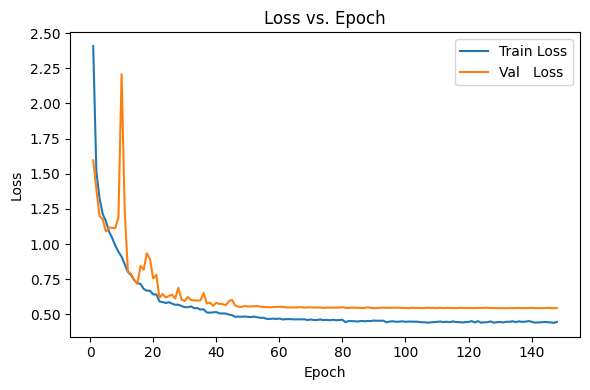

In [20]:
logger.plot()

In [14]:
# save the model
torch.save(model.state_dict(), "phase2_model.pth")

(16, 200, 300, 1)
(16, 200, 300)


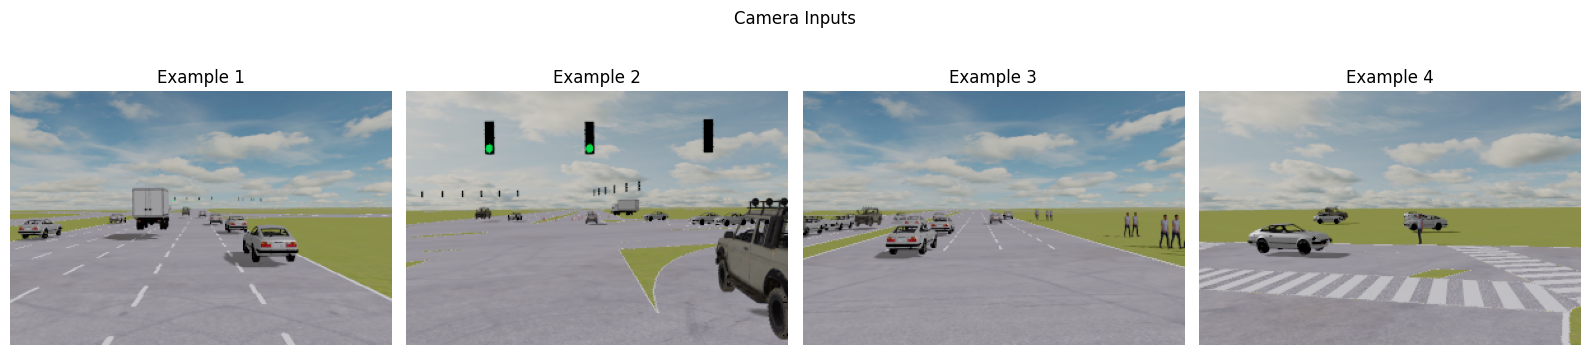

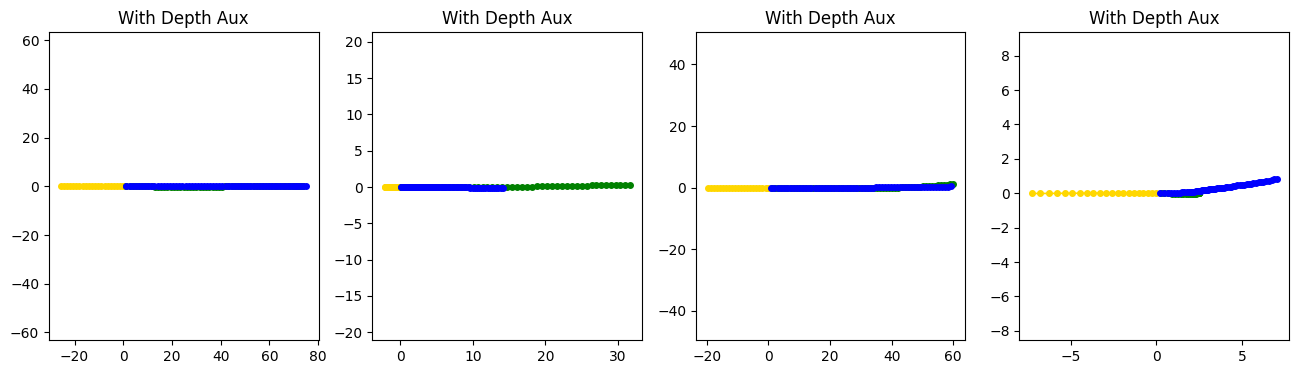

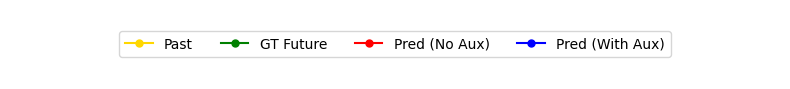

<Figure size 640x480 with 0 Axes>

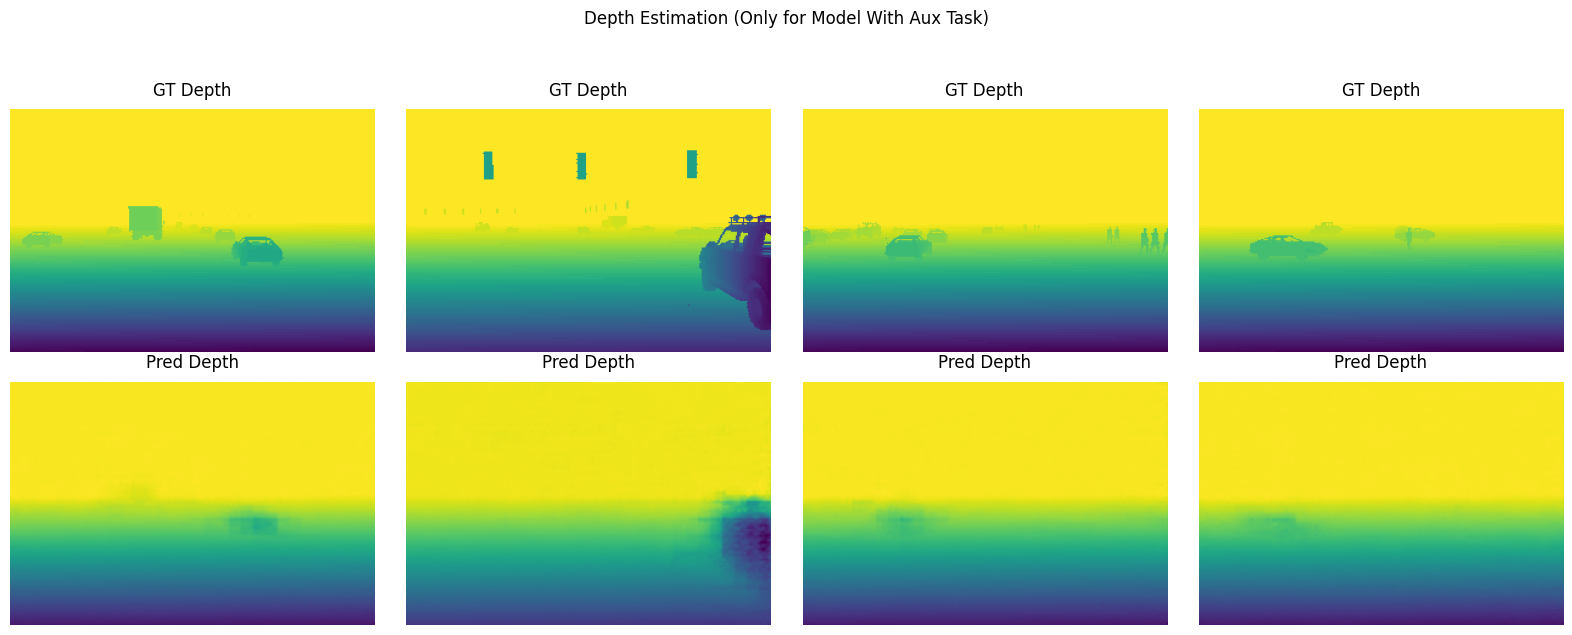

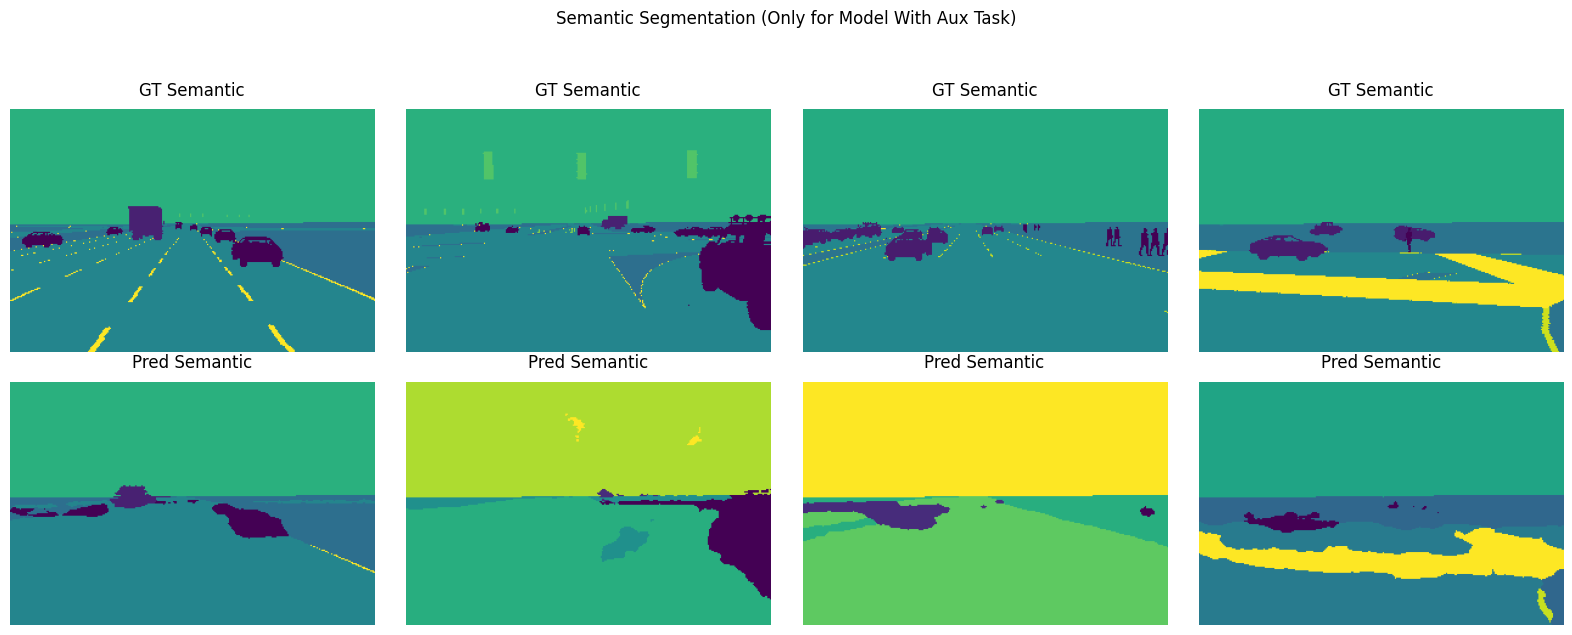

In [30]:
import matplotlib.pyplot as plt
import random


def visualize_comparison(val_loader, model_with_aux, device):
    # model_no_aux.eval()
    model_with_aux.eval()
    val_batch = next(iter(val_loader))

    camera = val_batch['camera'].to(device)
    history = val_batch['history'].to(device)
    future = val_batch['future'].to(device)
    depth = val_batch['depth'].to(device)
    sem = val_batch['semantic'].to(device)

    with torch.no_grad():
        # pred_no_aux, _, _ = model_no_aux(camera, history)
        pred_with_aux, pred_depth, pred_semantic = model_with_aux(camera, history)

    camera = camera.cpu().numpy()
    history = history.cpu().numpy()
    future = future.cpu().numpy()
    # pred_no_aux = pred_no_aux.cpu().numpy()
    pred_with_aux = pred_with_aux.cpu().numpy()
    depth = depth.cpu().numpy()
    sem = sem.cpu().numpy()
    pred_depth = pred_depth.cpu().numpy() if pred_depth is not None else None
    pred_semantic = pred_semantic.permute(0, 2, 3, 1) if pred_semantic is not None else None
    pred_semantic = pred_semantic.cpu().numpy() if pred_semantic is not None else None
    pred_semantic = np.argmax(pred_semantic, axis=-1) if pred_semantic is not None else None
    print(pred_depth.shape)
    print(pred_semantic.shape)

    k = 4
    indices = random.choices(np.arange(len(camera)), k=k)

    # Show the input camera images
    fig, ax = plt.subplots(1, k, figsize=(4 * k, 4))
    for i, idx in enumerate(indices):
        ax[i].imshow(camera[idx].transpose(1, 2, 0))
        ax[i].set_title(f"Example {i+1}")
        ax[i].axis("off")
    plt.suptitle("Camera Inputs")
    plt.tight_layout()
    plt.show()

    # Compare predicted trajectories
    fig, ax = plt.subplots(1, k, figsize=(4 * k, 4))
    for i, idx in enumerate(indices):

        # With aux
        ax[i].plot(history[idx, :, 0], history[idx, :, 1], 'o-', label='Past', color='gold', markersize=4, linewidth=1.2)
        ax[i].plot(future[idx, :, 0], future[idx, :, 1], 'o-', label='GT Future', color='green', markersize=4, linewidth=1.2)
        ax[i].plot(pred_with_aux[idx, :, 0], pred_with_aux[idx, :, 1], 'o-', label='Pred (With Aux)', color='blue', markersize=4, linewidth=1.2)
        ax[i].set_title("With Depth Aux")
        ax[i].axis("equal")

    # Show full legend in a new figure
    fig_legend = plt.figure(figsize=(8, 1))
    legend_handles = [
        plt.Line2D([0], [0], color='gold', marker='o', linestyle='-', markersize=5, label='Past'),
        plt.Line2D([0], [0], color='green', marker='o', linestyle='-', markersize=5, label='GT Future'),
        plt.Line2D([0], [0], color='red', marker='o', linestyle='-', markersize=5, label='Pred (No Aux)'),
        plt.Line2D([0], [0], color='blue', marker='o', linestyle='-', markersize=5, label='Pred (With Aux)')
    ]
    fig_legend.legend(handles=legend_handles, loc='center', ncol=4)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

    plt.suptitle("Trajectory Prediction: Without vs With Depth Aux Task")
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

    # Show predicted vs GT depth (only for bottom row)
    if pred_depth is not None:
        fig, ax = plt.subplots(2, k, figsize=(4 * k, 6))
        for i, idx in enumerate(indices):
            ax[0, i].imshow(depth[idx, :, :, 0], cmap='viridis')
            ax[0, i].set_title("GT Depth", pad=10)
            ax[0, i].axis("off")
            # increase vertical distance between rows

            ax[1, i].imshow(pred_depth[idx, :, :, 0], cmap='viridis')
            ax[1, i].set_title("Pred Depth", pad=10)
            ax[1, i].axis("off")

        plt.suptitle("Depth Estimation (Only for Model With Aux Task)", y=1.05)
        plt.subplots_adjust(hspace=0.4)
        plt.tight_layout()
        plt.show()

    if pred_semantic is not None:
        fig, ax = plt.subplots(2, k, figsize=(4 * k, 6))
        for i, idx in enumerate(indices):
            ax[0, i].imshow(sem[idx, :, :], cmap='viridis')
            ax[0, i].set_title("GT Semantic", pad=10)
            ax[0, i].axis("off")
            # increase vertical distance between rows

            ax[1, i].imshow(pred_semantic[idx, :, :], cmap='viridis')
            ax[1, i].set_title("Pred Semantic", pad=10)
            ax[1, i].axis("off")

        plt.suptitle("Semantic Segmentation (Only for Model With Aux Task)", y=1.05)
        plt.subplots_adjust(hspace=0.4)
        plt.tight_layout()
        plt.show()


# 🔚 Call at the end after training both models
visualize_comparison(val_loader, model, device=torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

Now we run our model on the test set once, to get the plan of our model and save it for submission. Notice that the ground truth plans are removed for the test set, so you can not calculate the ADE metric on the test set yourself, and need to submit it to the leader board. By running the last cell, you'll be able to see a csv file called `submission_phase1.csv` by clicking on the folder icon on the left. Download it and submit it to the leaderboard to get your score.

In [17]:
with open(f"phase2/test_public/0.pkl", "rb") as f:
    data = pickle.load(f)
print(data.keys())
# Note the absence of sdc_future_feature

dict_keys(['camera', 'depth', 'driving_command', 'sdc_history_feature', 'semantic_label'])


In [19]:
import pandas as pd
test_data_dir = "phase2/test_public"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
test_files = [os.path.join(test_data_dir, fn) for fn in sorted([f for f in os.listdir(test_data_dir) if f.endswith(".pkl")], key=lambda fn: int(os.path.splitext(fn)[0]))]
test_dataset = DrivingDataset(test_files, test=True)
test_loader = DataLoader(test_dataset, batch_size=250, num_workers=0)
model.eval()
all_plans = []
with torch.no_grad():
    for batch in test_loader:
        camera = batch['camera'].to(device)
        history = batch['history'].to(device)

        pred_future, _, _ = model(camera, history)
        all_plans.append(pred_future.cpu().numpy()[..., :2])
all_plans = np.concatenate(all_plans, axis=0)

# Now save the plans as a csv file
pred_xy = all_plans[..., :2]  # shape: (total_samples, T, 2)

# Flatten to (total_samples, T*2)
total_samples, T, D = pred_xy.shape
pred_xy_flat = pred_xy.reshape(total_samples, T * D)

# Build a DataFrame with an ID column
ids = np.arange(total_samples)
df_xy = pd.DataFrame(pred_xy_flat)
df_xy.insert(0, "id", ids)

# Column names: id, x_1, y_1, x_2, y_2, ..., x_T, y_T
new_col_names = ["id"]
for t in range(1, T + 1):
    new_col_names.append(f"x_{t}")
    new_col_names.append(f"y_{t}")
df_xy.columns = new_col_names

# Save to CSV
df_xy.to_csv("submission_phase2.csv", index=False)

print(f"Shape of df_xy: {df_xy.shape}")

Shape of df_xy: (1000, 121)
